In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [13]:
def drawROC(indexName, predictions):
    X, Y = roc.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.plot([0, 1], [0, 1], ls='--')
    plt.legend(handles=[curve], loc=4)
def drawPR(indexName, predictions):
    X, Y = pr.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.legend(handles=[curve])
def drawROCs(supTitle, **args):
    predictions = args["predictions"]
    indexNames = args["indexNames"]
    plt.suptitle(supTitle, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], '#aaaaaa', ls='--')
    handles = []
    for i in range(0, len(indexNames)):
        X, Y = roc.getCurve(predictions[i])
        curve, = plt.plot(X, Y, label=indexNames[i])
        handles.append(curve)
    plt.legend(handles=handles, loc=4, fontsize=10)

In [14]:
testGraph = readGraph("input/jazz.graph", Format.METIS)

In [15]:
trainingGraph = linkprediction.TrainingGraphSampler.byPercentage(testGraph, 0.7)
print("Train / Test =", trainingGraph.numberOfEdges(), "/", testGraph.numberOfEdges())

Train / Test = 1919 / 2742


In [16]:
missingLinks = linkprediction.MissingLinksFinder(trainingGraph).findAll(2)
missingLinks.sort()
print("Found", len(missingLinks), "missing links")

Found 8564 missing links


In [17]:
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)

In [18]:
linkPredictors = (commonNeighborsIndex, jaccardIndex, adamicAdarIndex)

In [47]:
positiveInstances = trainingGraph.randomEdges(25000)
negativeInstances = []
while len(negativeInstances) < 25000:
    u = trainingGraph.randomNode()
    v = trainingGraph.randomNode()
    if (u != v and not (testGraph.hasEdge(u, v) or testGraph.hasEdge(u, v)) and not (trainingGraph.hasEdge(u, v) or trainingGraph.hasEdge(u, v)) and trainingGraph.degree(u) > 0 and trainingGraph.degree(v) > 0):
        negativeInstances.append((u, v))
allInstances = positiveInstances + negativeInstances
random.shuffle(allInstances)
allInstances = np.array(allInstances)

nodePairsTrain = allInstances[:40000]
nodePairsTest = allInstances[-10000:]
#np.sort(nodePairsTrain, axis=0)

nodePairsTrain.sort(axis=0)
nodePairsTest.sort(axis=0)

classesTrain = linkprediction.getClasses(nodePairsTrain, testGraph)
samplesTrain = linkprediction.getSamples(nodePairsTrain, *linkPredictors)

classesTest = linkprediction.getClasses(nodePairsTest, testGraph)
samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)

In [54]:
tmp = linkprediction.TrainingGraphSampler.byPercentage(trainingGraph, 0.7)
nodePairsTrain = linkprediction.MissingLinksFinder(tmp).findAll(2)
nodePairsTrain.sort()
print(len(supervisedTrainingNodePairs))
positives = linkprediction.getClasses(supervisedTrainingNodePairs, trainingGraph)
print(sum(positives))
nodePairsTest = missingLinks
nodePairsTest.sort()

classesTrain = linkprediction.getClasses(nodePairsTrain, testGraph)
samplesTrain = linkprediction.getSamples(nodePairsTrain, *linkPredictors)

classesTest = linkprediction.getClasses(nodePairsTest, testGraph)
samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)

6651
503


In [55]:
roc = linkprediction.ROCMetric(testGraph)
pr = linkprediction.PrecisionRecallMetric(testGraph)

In [56]:
dtc = ensemble.AdaBoostClassifier()
#dtc = tree.DecisionTreeClassifier()
linkprediction.trainClassifier(nodePairsTrain, testGraph, dtc, *linkPredictors)

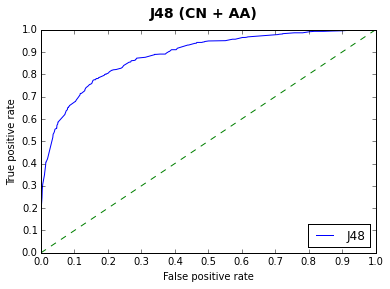

In [57]:
predictionsKNN = dtc.predict_proba(samplesTest)
isEdgePred = [x[1] for x in predictionsKNN]
#sum = 0
#for i in range(0, len(predictionsKNN)):
#    if predictionsKNN[i] == classesTest[i]:
#        sum +=1
#sum
fpr, tpr, thresholds = metrics.roc_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(fpr, tpr, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [31]:
startTime = time.time()
predictions = commonNeighborsIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))
predictions

0.009963035583496094 seconds


[((0, 6), 6.0),
 ((0, 8), 1.0),
 ((0, 9), 1.0),
 ((0, 15), 1.0),
 ((0, 17), 2.0),
 ((0, 19), 1.0),
 ((0, 21), 6.0),
 ((0, 22), 1.0),
 ((0, 31), 7.0),
 ((0, 32), 3.0),
 ((0, 34), 12.0),
 ((0, 35), 1.0),
 ((0, 39), 6.0),
 ((0, 41), 2.0),
 ((0, 42), 5.0),
 ((0, 43), 6.0),
 ((0, 45), 6.0),
 ((0, 49), 2.0),
 ((0, 52), 1.0),
 ((0, 53), 1.0),
 ((0, 54), 1.0),
 ((0, 55), 2.0),
 ((0, 57), 5.0),
 ((0, 59), 10.0),
 ((0, 61), 5.0),
 ((0, 62), 6.0),
 ((0, 63), 6.0),
 ((0, 64), 6.0),
 ((0, 65), 6.0),
 ((0, 67), 2.0),
 ((0, 68), 4.0),
 ((0, 69), 5.0),
 ((0, 70), 2.0),
 ((0, 71), 1.0),
 ((0, 72), 1.0),
 ((0, 77), 3.0),
 ((0, 79), 1.0),
 ((0, 81), 1.0),
 ((0, 82), 7.0),
 ((0, 87), 1.0),
 ((0, 90), 2.0),
 ((0, 92), 1.0),
 ((0, 93), 3.0),
 ((0, 100), 9.0),
 ((0, 102), 4.0),
 ((0, 103), 5.0),
 ((0, 104), 9.0),
 ((0, 105), 4.0),
 ((0, 106), 7.0),
 ((0, 107), 11.0),
 ((0, 108), 7.0),
 ((0, 109), 7.0),
 ((0, 110), 3.0),
 ((0, 111), 1.0),
 ((0, 113), 3.0),
 ((0, 116), 1.0),
 ((0, 117), 4.0),
 ((0, 120), 2.0),

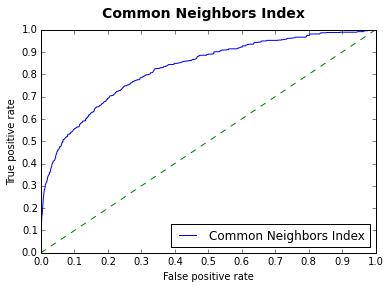

In [29]:
drawROC("Common Neighbors Index", predictions)